In [44]:
# ============================================================================
# IMPORTANT: Notebook Environment Detection
# ============================================================================

import os
import sys

print("=" * 70)
print("NOTEBOOK ENVIRONMENT DETECTION")
print("=" * 70)
print(f"Platform: {sys.platform}")
print(f"Current directory: {os.getcwd()}")

# This notebook is designed to work with your Urdu-English translation data
# The data files should be in the same directory as this notebook

data_files = ['urd_Arab.dev', 'urd_Arab.devtest', 'eng_Latn.dev', 'eng_Latn.devtest', 'multi-bleu.perl']
missing_files = [f for f in data_files if not os.path.exists(f)]

if not missing_files:
    print(f"\n✓ All required files found! Ready to proceed.")
else:
    print(f"\n⚠ This notebook is running in a REMOTE environment (e.g., Google Colab)")
    print(f"   The data files are not accessible from: {os.getcwd()}")
    print(f"\n📋 TO RUN THIS NOTEBOOK:")
    print(f"   Option 1: Run locally in VS Code/Jupyter with local Python kernel")
    print(f"   Option 2: Upload files if in Colab (but VS Code local kernel is recommended)")
    print(f"\n📁 Required files (should be in notebook directory):")
    for f in data_files:
        status = "✓" if f not in missing_files else "✗"
        print(f"   {status} {f}")
    
    print(f"\n💡 RECOMMENDED: Use 'Select Kernel' in VS Code and choose a LOCAL Python environment")
    print(f"   This will allow the notebook to access files in your workspace.")

print("=" * 70)

NOTEBOOK ENVIRONMENT DETECTION
Platform: linux
Current directory: /content

⚠ This notebook is running in a REMOTE environment (e.g., Google Colab)
   The data files are not accessible from: /content

📋 TO RUN THIS NOTEBOOK:
   Option 1: Run locally in VS Code/Jupyter with local Python kernel
   Option 2: Upload files if in Colab (but VS Code local kernel is recommended)

📁 Required files (should be in notebook directory):
   ✗ urd_Arab.dev
   ✗ urd_Arab.devtest
   ✗ eng_Latn.dev
   ✗ eng_Latn.devtest
   ✗ multi-bleu.perl

💡 RECOMMENDED: Use 'Select Kernel' in VS Code and choose a LOCAL Python environment
   This will allow the notebook to access files in your workspace.


In [31]:
"""
RNN with Attention-based Encoder-Decoder Model for Urdu to English Translation
Custom LSTM Implementation (without using nn.LSTM or nn.RNN)
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import subprocess
import os
from pathlib import Path

In [16]:
# ============================================================================
# CUSTOM LSTM CELL IMPLEMENTATION (No nn.LSTM or nn.RNN used)
# ============================================================================

class LSTMCell(nn.Module):
    """
    Custom LSTM Cell implementation from scratch.
    LSTM has 4 gates: input gate (i), forget gate (f), cell gate (g), output gate (o)
    
    Args:
        input_size: Size of input features
        hidden_size: Size of hidden state
    """
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        # Weight matrices for input-to-hidden connections
        self.W_ii = nn.Linear(input_size, hidden_size)  # Input gate
        self.W_if = nn.Linear(input_size, hidden_size)  # Forget gate
        self.W_ig = nn.Linear(input_size, hidden_size)  # Cell gate
        self.W_io = nn.Linear(input_size, hidden_size)  # Output gate
        
        # Weight matrices for hidden-to-hidden connections
        self.W_hi = nn.Linear(hidden_size, hidden_size)  # Input gate
        self.W_hf = nn.Linear(hidden_size, hidden_size)  # Forget gate
        self.W_hg = nn.Linear(hidden_size, hidden_size)  # Cell gate
        self.W_ho = nn.Linear(hidden_size, hidden_size)  # Output gate
        
    def forward(self, x, hidden_state):
        """
        Forward pass through LSTM cell.
        
        Args:
            x: Input tensor of shape (batch_size, input_size)
            hidden_state: Tuple of (h, c) where each is (batch_size, hidden_size)
            
        Returns:
            new_h: New hidden state (batch_size, hidden_size)
            new_c: New cell state (batch_size, hidden_size)
        """
        h, c = hidden_state
        
        # Input gate: decides what new information to store
        i = torch.sigmoid(self.W_ii(x) + self.W_hi(h))
        
        # Forget gate: decides what information to discard
        f = torch.sigmoid(self.W_if(x) + self.W_hf(h))
        
        # Cell gate: creates candidate values to add to cell state
        g = torch.tanh(self.W_ig(x) + self.W_hg(h))
        
        # Output gate: decides what to output
        o = torch.sigmoid(self.W_io(x) + self.W_ho(h))
        
        # Update cell state: forget old info and add new info
        new_c = f * c + i * g
        
        # Update hidden state: output filtered cell state
        new_h = o * torch.tanh(new_c)
        
        return new_h, new_c

In [17]:
# ============================================================================
# CUSTOM LSTM LAYER (Using our custom LSTM cells)
# ============================================================================

class CustomLSTM(nn.Module):
    """
    Custom LSTM layer that processes sequences using custom LSTM cells.
    
    Args:
        input_size: Size of input features
        hidden_size: Size of hidden state
        num_layers: Number of stacked LSTM layers
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList([
            LSTMCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
    def forward(self, x, hidden=None):
        """
        Forward pass through LSTM layer.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            hidden: Optional initial hidden state tuple (h, c)
            
        Returns:
            outputs: All hidden states (batch_size, seq_len, hidden_size)
            (h, c): Final hidden and cell states
        """
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states if not provided
        if hidden is None:
            h = [torch.zeros(batch_size, self.hidden_size, device=x.device) 
                 for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size, device=x.device) 
                 for _ in range(self.num_layers)]
        else:
            h, c = hidden
            h = [h[i] for i in range(self.num_layers)]
            c = [c[i] for i in range(self.num_layers)]
        
        outputs = []
        
        # Process each time step
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.lstm_cells[layer](x_t, (h[layer], c[layer]))
                x_t = h[layer]  # Output of current layer is input to next layer
            
            outputs.append(h[-1])  # Collect output from last layer
        
        # Stack outputs along sequence dimension
        outputs = torch.stack(outputs, dim=1)
        
        # Stack hidden and cell states
        h_final = torch.stack(h, dim=0)
        c_final = torch.stack(c, dim=0)
        
        return outputs, (h_final, c_final)

In [18]:
# ============================================================================
# ENCODER with Custom LSTM
# ============================================================================

class Encoder(nn.Module):
    """
    Encoder that uses custom LSTM to encode source sequences.
    
    Args:
        vocab_size: Size of source vocabulary
        embed_size: Size of embedding vectors
        hidden_size: Size of LSTM hidden states
        num_layers: Number of LSTM layers
        dropout: Dropout probability
    """
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Custom LSTM layer
        self.lstm = CustomLSTM(embed_size, hidden_size, num_layers)
        
    def forward(self, src):
        """
        Forward pass through encoder.
        
        Args:
            src: Source sequences (batch_size, seq_len)
            
        Returns:
            outputs: All encoder hidden states (batch_size, seq_len, hidden_size)
            hidden: Final hidden state (num_layers, batch_size, hidden_size)
            cell: Final cell state (num_layers, batch_size, hidden_size)
        """
        # Embed source sequences
        embedded = self.dropout(self.embedding(src))  # (batch_size, seq_len, embed_size)
        
        # Pass through LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        
        return outputs, hidden, cell

In [19]:
# ============================================================================
# ATTENTION MECHANISM (Bahdanau Attention)
# ============================================================================

class BahdanauAttention(nn.Module):
    """
    Bahdanau (additive) attention mechanism.
    Computes attention weights to focus on relevant parts of encoder outputs.
    
    Args:
        hidden_size: Size of hidden states
    """
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        
        # Learnable weight matrices
        self.W_a = nn.Linear(hidden_size, hidden_size, bias=False)  # For encoder outputs
        self.U_a = nn.Linear(hidden_size, hidden_size, bias=False)  # For decoder hidden state
        self.v_a = nn.Linear(hidden_size, 1, bias=False)  # To compute scalar score
        
    def forward(self, decoder_hidden, encoder_outputs):
        """
        Compute attention weights and context vector.
        
        Args:
            decoder_hidden: Current decoder hidden state (batch_size, hidden_size)
            encoder_outputs: All encoder hidden states (batch_size, src_len, hidden_size)
            
        Returns:
            context: Context vector (batch_size, hidden_size)
            attention_weights: Attention weights (batch_size, src_len)
        """
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Expand decoder hidden to match encoder outputs shape
        # (batch_size, hidden_size) -> (batch_size, src_len, hidden_size)
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Compute attention scores (energy)
        # score = v_a^T * tanh(W_a * encoder_outputs + U_a * decoder_hidden)
        energy = torch.tanh(
            self.W_a(encoder_outputs) + self.U_a(decoder_hidden)
        )  # (batch_size, src_len, hidden_size)
        
        attention_scores = self.v_a(energy).squeeze(2)  # (batch_size, src_len)
        
        # Compute attention weights using softmax
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, src_len)
        
        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(
            attention_weights.unsqueeze(1), encoder_outputs
        ).squeeze(1)  # (batch_size, hidden_size)
        
        return context, attention_weights

In [20]:
# ============================================================================
# DECODER with Custom LSTM and Attention
# ============================================================================

class Decoder(nn.Module):
    """
    Decoder that uses custom LSTM with attention mechanism.
    
    Args:
        vocab_size: Size of target vocabulary
        embed_size: Size of embedding vectors
        hidden_size: Size of LSTM hidden states
        num_layers: Number of LSTM layers
        dropout: Dropout probability
    """
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Attention mechanism
        self.attention = BahdanauAttention(hidden_size)
        
        # Custom LSTM layer (input = embedding + context)
        self.lstm = CustomLSTM(embed_size + hidden_size, hidden_size, num_layers)
        
        # Output projection layer (hidden + context -> vocab)
        self.fc_out = nn.Linear(hidden_size * 2, vocab_size)
        
    def forward(self, target, hidden, cell, encoder_outputs):
        """
        Forward pass through decoder for one time step.
        
        Args:
            target: Target token (batch_size)
            hidden: Previous hidden state (num_layers, batch_size, hidden_size)
            cell: Previous cell state (num_layers, batch_size, hidden_size)
            encoder_outputs: All encoder hidden states (batch_size, src_len, hidden_size)
            
        Returns:
            output: Prediction logits (batch_size, vocab_size)
            hidden: New hidden state
            cell: New cell state
            attention_weights: Attention weights for visualization
        """
        # Embed target token
        target = target.unsqueeze(1)  # (batch_size, 1)
        embedded = self.dropout(self.embedding(target))  # (batch_size, 1, embed_size)
        
        # Use last layer's hidden state for attention
        decoder_hidden = hidden[-1]  # (batch_size, hidden_size)
        
        # Compute attention context
        context, attention_weights = self.attention(decoder_hidden, encoder_outputs)
        
        # Concatenate embedding and context
        context = context.unsqueeze(1)  # (batch_size, 1, hidden_size)
        lstm_input = torch.cat([embedded, context], dim=2)  # (batch_size, 1, embed_size + hidden_size)
        
        # Pass through LSTM
        lstm_output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # lstm_output: (batch_size, 1, hidden_size)
        
        # Concatenate LSTM output with context for prediction
        lstm_output = lstm_output.squeeze(1)  # (batch_size, hidden_size)
        context = context.squeeze(1)  # (batch_size, hidden_size)
        
        # Generate output logits
        output = self.fc_out(torch.cat([lstm_output, context], dim=1))  # (batch_size, vocab_size)
        
        return output, hidden, cell, attention_weights

In [21]:
# ============================================================================
# SEQ2SEQ MODEL (Combining Encoder and Decoder)
# ============================================================================

class Seq2Seq(nn.Module):
    """
    Sequence-to-Sequence model with attention for machine translation.
    
    Args:
        encoder: Encoder module
        decoder: Decoder module
        device: Device to run on (CPU or CUDA)
    """
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Forward pass through the entire model.
        
        Args:
            src: Source sequences (batch_size, src_len)
            trg: Target sequences (batch_size, trg_len)
            teacher_forcing_ratio: Probability of using teacher forcing
            
        Returns:
            outputs: Prediction logits (batch_size, trg_len, vocab_size)
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.vocab_size
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Encode source sequence
        encoder_outputs, hidden, cell = self.encoder(src)
        
        # First input to decoder is <sos> token
        decoder_input = trg[:, 0]
        
        # Decode sequence one token at a time
        for t in range(1, trg_len):
            # Forward pass through decoder
            output, hidden, cell, _ = self.decoder(
                decoder_input, hidden, cell, encoder_outputs
            )
            
            # Store prediction
            outputs[:, t, :] = output
            
            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Get the predicted token
            top1 = output.argmax(1)
            
            # Next input: ground truth if teacher forcing, else predicted token
            decoder_input = trg[:, t] if teacher_force else top1
            
        return outputs

In [ ]:
# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_prepare_data(data_dir="."):
    """
    Load Urdu and English parallel data, combine dev and devtest files,
    shuffle, and split into train (70%), validation (15%), and test (15%).
    
    Args:
        data_dir: Directory containing data files (default: current directory)
    
    Returns:
        Preprocessed data splits and vocabularies
    """
    print("Loading data...")
    
    # Load Urdu (source) data
    with open(os.path.join(data_dir, "urd_Arab.dev"), "r", encoding="utf-8") as f:
        urdu_dev = [line.strip() for line in f.readlines()]
    with open(os.path.join(data_dir, "urd_Arab.devtest"), "r", encoding="utf-8") as f:
        urdu_devtest = [line.strip() for line in f.readlines()]
    
    # Load English (target) data
    with open(os.path.join(data_dir, "eng_Latn.dev"), "r", encoding="utf-8") as f:
        eng_dev = [line.strip() for line in f.readlines()]
    with open(os.path.join(data_dir, "eng_Latn.devtest"), "r", encoding="utf-8") as f:
        eng_devtest = [line.strip() for line in f.readlines()]
    
    # Combine dev and devtest
    urdu_sentences = urdu_dev + urdu_devtest
    eng_sentences = eng_dev + eng_devtest
    
    print(f"Total sentences: {len(urdu_sentences)}")
    
    # Combine and shuffle
    combined = list(zip(urdu_sentences, eng_sentences))
    random.seed(42)
    random.shuffle(combined)
    urdu_sentences, eng_sentences = zip(*combined)
    
    # Split: 70% train, 15% val, 15% test
    train_src, temp_src, train_tgt, temp_tgt = train_test_split(
        urdu_sentences, eng_sentences, test_size=0.3, random_state=42
    )
    val_src, test_src, val_tgt, test_tgt = train_test_split(
        temp_src, temp_tgt, test_size=0.5, random_state=42
    )
    
    print(f"Train: {len(train_src)}, Val: {len(val_src)}, Test: {len(test_src)}")
    
    return (train_src, train_tgt, val_src, val_tgt, test_src, test_tgt,
            urdu_sentences, eng_sentences)

In [23]:
# ============================================================================
# VOCABULARY BUILDING
# ============================================================================

def build_vocab(sentences, min_freq=2):
    """
    Build vocabulary from sentences with special tokens.
    
    Args:
        sentences: List of sentences
        min_freq: Minimum frequency for a word to be included
        
    Returns:
        vocab: Dictionary mapping tokens to indices
        idx_to_token: Dictionary mapping indices to tokens
    """
    # Special tokens
    special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
    
    # Count word frequencies
    word_freq = {}
    for sentence in sentences:
        for word in sentence.split():
            word_freq[word] = word_freq.get(word, 0) + 1
    
    # Filter by minimum frequency
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    idx = len(vocab)
    
    for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True):
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    
    idx_to_token = {idx: token for token, idx in vocab.items()}
    
    print(f"Vocabulary size: {len(vocab)}")
    
    return vocab, idx_to_token


def tokenize_sentence(sentence, vocab, max_len):
    """
    Convert sentence to token indices with padding.
    
    Args:
        sentence: Input sentence string
        vocab: Vocabulary dictionary
        max_len: Maximum sequence length
        
    Returns:
        List of token indices
    """
    tokens = [vocab.get(word, vocab["<unk>"]) for word in sentence.split()]
    
    # Truncate if too long
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    
    # Pad if too short
    while len(tokens) < max_len:
        tokens.append(vocab["<pad>"])
    
    return tokens


def prepare_data(src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len_src, max_len_tgt):
    """
    Prepare data by tokenizing and converting to tensors.
    
    Args:
        src_sentences: Source sentences
        tgt_sentences: Target sentences
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        max_len_src: Max source sequence length
        max_len_tgt: Max target sequence length
        
    Returns:
        src_tensor: Source sequences tensor
        tgt_tensor: Target sequences tensor (with <sos> and <eos>)
    """
    src_data = []
    tgt_data = []
    
    for src, tgt in zip(src_sentences, tgt_sentences):
        # Tokenize source
        src_tokens = tokenize_sentence(src, src_vocab, max_len_src)
        
        # Add <sos> and <eos> to target
        tgt_with_special = f"<sos> {tgt} <eos>"
        tgt_tokens = tokenize_sentence(tgt_with_special, tgt_vocab, max_len_tgt)
        
        src_data.append(src_tokens)
        tgt_data.append(tgt_tokens)
    
    src_tensor = torch.tensor(src_data, dtype=torch.long)
    tgt_tensor = torch.tensor(tgt_data, dtype=torch.long)
    
    return src_tensor, tgt_tensor

In [24]:
# ============================================================================
# DATASET CLASS
# ============================================================================

class TranslationDataset(Dataset):
    """
    Dataset class for machine translation.
    """
    def __init__(self, src_tensor, tgt_tensor):
        self.src_tensor = src_tensor
        self.tgt_tensor = tgt_tensor
        
    def __len__(self):
        return len(self.src_tensor)
    
    def __getitem__(self, idx):
        return self.src_tensor[idx], self.tgt_tensor[idx]

In [ ]:
# ============================================================================
# BLEU SCORE CALCULATION
# ============================================================================

def calculate_bleu_score(model, data_loader, src_vocab, tgt_vocab, device, data_dir="."):
    """
    Calculate BLEU score using Moses multi-bleu.perl script.
    
    Args:
        model: Trained model
        data_loader: DataLoader for evaluation
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        device: Device to run on
        data_dir: Directory for output files and perl script
        
    Returns:
        bleu_score: BLEU score as float
    """
    model.eval()
    
    predictions = []
    references = []
    
    idx_to_tgt = {idx: token for token, idx in tgt_vocab.items()}
    
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate predictions (no teacher forcing)
            output = model(src, tgt, teacher_forcing_ratio=0)
            output = output.argmax(2)  # Get predicted token indices
            
            # Convert to text (skip <pad>, <sos>, <eos>)
            for pred, ref in zip(output, tgt):
                pred_text = []
                ref_text = []
                
                for idx in pred:
                    token = idx_to_tgt.get(idx.item(), "<unk>")
                    if token not in ["<pad>", "<sos>", "<eos>"]:
                        pred_text.append(token)
                
                for idx in ref:
                    token = idx_to_tgt.get(idx.item(), "<unk>")
                    if token not in ["<pad>", "<sos>", "<eos>"]:
                        ref_text.append(token)
                
                predictions.append(" ".join(pred_text))
                references.append(" ".join(ref_text))
    
    # Save to files for multi-bleu.perl
    pred_file = os.path.join(data_dir, "predictions.txt")
    ref_file = os.path.join(data_dir, "references.txt")
    
    with open(pred_file, "w", encoding="utf-8") as f:
        for pred in predictions:
            f.write(pred + "\n")
    
    with open(ref_file, "w", encoding="utf-8") as f:
        for ref in references:
            f.write(ref + "\n")
    
    # Run multi-bleu.perl script
    try:
        bleu_script = os.path.join(data_dir, "multi-bleu.perl")
        result = subprocess.run(
            ["perl", bleu_script, ref_file],
            stdin=open(pred_file, "r", encoding="utf-8"),
            capture_output=True,
            text=True
        )
        
        bleu_output = result.stdout.strip()
        print(f"BLEU: {bleu_output}")
        
        # Extract BLEU score
        if "BLEU = " in bleu_output:
            bleu_score = float(bleu_output.split("BLEU = ")[1].split(",")[0])
        else:
            bleu_score = 0.0
            
    except Exception as e:
        print(f"Error calculating BLEU: {e}")
        bleu_score = 0.0
    
    return bleu_score

In [ ]:
# ============================================================================
# TRAINING FUNCTION with BLEU Score Tracking
# ============================================================================

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs, 
                src_vocab, tgt_vocab, data_dir="."):
    """
    Train the model and track loss and BLEU scores.
    
    Args:
        model: Seq2Seq model
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer
        criterion: Loss function
        device: Device to run on
        epochs: Number of epochs
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        data_dir: Directory for saving files
        
    Returns:
        Dictionary containing training history
    """
    train_losses = []
    val_losses = []
    train_bleu_scores = []
    val_bleu_scores = []
    
    print("Starting training...")
    print("=" * 70)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(src, tgt, teacher_forcing_ratio=0.5)
            
            # Reshape for loss calculation (ignore first token <sos>)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)
            
            # Calculate loss
            loss = criterion(output, tgt)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        # Average training loss
        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        batch_count = 0
        
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                
                # Forward pass (no teacher forcing)
                output = model(src, tgt, teacher_forcing_ratio=0)
                
                # Reshape for loss calculation
                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                tgt = tgt[:, 1:].reshape(-1)
                
                # Calculate loss
                loss = criterion(output, tgt)
                val_loss += loss.item()
                batch_count += 1
        
        # Average validation loss
        avg_val_loss = val_loss / batch_count
        val_losses.append(avg_val_loss)
        
        # Calculate BLEU scores (every few epochs to save time)
        if (epoch + 1) % 2 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Calculating BLEU scores for epoch {epoch + 1}...")
            train_bleu = calculate_bleu_score(model, train_loader, src_vocab, tgt_vocab, device, data_dir)
            val_bleu = calculate_bleu_score(model, val_loader, src_vocab, tgt_vocab, device, data_dir)
            train_bleu_scores.append((epoch + 1, train_bleu))
            val_bleu_scores.append((epoch + 1, val_bleu))
        else:
            # Use previous BLEU scores
            if train_bleu_scores:
                train_bleu = train_bleu_scores[-1][1]
                val_bleu = val_bleu_scores[-1][1]
            else:
                train_bleu, val_bleu = 0, 0
        
        # Print progress
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"  Train BLEU: {train_bleu:.2f} | Val BLEU: {val_bleu:.2f}")
        print("-" * 70)
    
    print("Training completed!")
    print("=" * 70)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_bleu_scores': train_bleu_scores,
        'val_bleu_scores': val_bleu_scores
    }

In [ ]:
# ============================================================================
# EVALUATION AND VISUALIZATION
# ============================================================================

def plot_training_curves(history, data_dir="."):
    """
    Plot loss and BLEU score curves for training and validation.
    
    Args:
        history: Dictionary containing training history
        data_dir: Directory to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss curves
    epochs = range(1, len(history['train_losses']) + 1)
    ax1.plot(epochs, history['train_losses'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot BLEU score curves
    train_epochs, train_bleu = zip(*history['train_bleu_scores'])
    val_epochs, val_bleu = zip(*history['val_bleu_scores'])
    
    ax2.plot(train_epochs, train_bleu, 'b-o', label='Train BLEU', linewidth=2, markersize=6)
    ax2.plot(val_epochs, val_bleu, 'r-o', label='Validation BLEU', linewidth=2, markersize=6)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('BLEU Score', fontsize=12)
    ax2.set_title('Training and Validation BLEU Score', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = os.path.join(data_dir, 'training_curves.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Training curves saved as '{plot_path}'")


def translate_sentence(sentence, model, src_vocab, tgt_vocab, device, max_len=50):
    """
    Translate a single sentence from Urdu to English.
    
    Args:
        sentence: Urdu sentence to translate
        model: Trained model
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        device: Device to run on
        max_len: Maximum sequence length
        
    Returns:
        Translated English sentence
    """
    model.eval()
    
    idx_to_tgt = {idx: token for token, idx in tgt_vocab.items()}
    
    # Tokenize source sentence
    tokens = tokenize_sentence(sentence, src_vocab, max_len)
    src_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    # Create dummy target (just <sos> token repeated)
    tgt_tensor = torch.tensor([[tgt_vocab['<sos>']] * max_len], dtype=torch.long).to(device)
    
    with torch.no_grad():
        # Get encoder outputs
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
        
        # Start with <sos> token
        decoder_input = torch.tensor([tgt_vocab['<sos>']], dtype=torch.long).to(device)
        
        translated_tokens = []
        
        # Generate tokens one by one
        for _ in range(max_len):
            output, hidden, cell, _ = model.decoder(decoder_input, hidden, cell, encoder_outputs)
            
            # Get predicted token
            predicted_token = output.argmax(1).item()
            
            # Stop if <eos> token is predicted
            if predicted_token == tgt_vocab['<eos>']:
                break
            
            # Add token to translation
            token_str = idx_to_tgt.get(predicted_token, '<unk>')
            if token_str not in ['<pad>', '<sos>']:
                translated_tokens.append(token_str)
            
            # Use predicted token as next input
            decoder_input = torch.tensor([predicted_token], dtype=torch.long).to(device)
    
    return ' '.join(translated_tokens)


def evaluate_test_set(model, test_loader, src_vocab, tgt_vocab, device, data_dir="."):
    """
    Evaluate model on test set and print final BLEU score.
    
    Args:
        model: Trained model
        test_loader: Test data loader
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        device: Device to run on
        data_dir: Directory for saving files
        
    Returns:
        test_bleu: BLEU score on test set
    """
    print("\n" + "=" * 70)
    print("EVALUATING ON TEST SET")
    print("=" * 70)
    
    test_bleu = calculate_bleu_score(model, test_loader, src_vocab, tgt_vocab, device, data_dir)
    
    print(f"\nFinal Test BLEU Score: {test_bleu:.2f}")
    print("=" * 70)
    
    return test_bleu


def create_results_table(history, test_bleu, data_dir="."):
    """
    Create and display comparative results table.
    
    Args:
        history: Training history dictionary
        test_bleu: Test set BLEU score
        data_dir: Directory to save the table
    """
    print("\n" + "=" * 70)
    print("COMPARATIVE RESULTS TABLE")
    print("=" * 70)
    print(f"{'Dataset':<20} {'Final Loss':<15} {'Final BLEU Score':<20}")
    print("-" * 70)
    
    # Get final values
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_bleu = history['train_bleu_scores'][-1][1]
    final_val_bleu = history['val_bleu_scores'][-1][1]
    
    print(f"{'Training Set':<20} {final_train_loss:<15.4f} {final_train_bleu:<20.2f}")
    print(f"{'Validation Set':<20} {final_val_loss:<15.4f} {final_val_bleu:<20.2f}")
    print(f"{'Test Set':<20} {'-':<15} {test_bleu:<20.2f}")
    print("=" * 70)
    
    # Save to file
    table_path = os.path.join(data_dir, "results_table.txt")
    with open(table_path, "w", encoding="utf-8") as f:
        f.write("COMPARATIVE RESULTS TABLE\n")
        f.write("=" * 70 + "\n")
        f.write(f"{'Dataset':<20} {'Final Loss':<15} {'Final BLEU Score':<20}\n")
        f.write("-" * 70 + "\n")
        f.write(f"{'Training Set':<20} {final_train_loss:<15.4f} {final_train_bleu:<20.2f}\n")
        f.write(f"{'Validation Set':<20} {final_val_loss:<15.4f} {final_val_bleu:<20.2f}\n")
        f.write(f"{'Test Set':<20} {'-':<15} {test_bleu:<20.2f}\n")
        f.write("=" * 70 + "\n")
    
    print(f"Results table saved to '{table_path}'")

In [40]:
# ============================================================================
# STEP 1: Load and Prepare Data
# ============================================================================

# Load data
(train_src, train_tgt, val_src, val_tgt, test_src, test_tgt,
 all_urdu, all_eng) = load_and_prepare_data()

# Build vocabularies
print("\nBuilding vocabularies...")
urdu_vocab, urdu_idx_to_token = build_vocab(all_urdu, min_freq=2)
eng_vocab, eng_idx_to_token = build_vocab(all_eng, min_freq=2)

print(f"Urdu vocab size: {len(urdu_vocab)}")
print(f"English vocab size: {len(eng_vocab)}")

Platform: linux
Current directory: /content
Available paths:
  /mnt/ exists: True
  /mnt/c/ exists: False

Files: []


In [ ]:
# ============================================================================
# STEP 2: Prepare Tensors and DataLoaders
# ============================================================================

# Define maximum sequence lengths
MAX_LEN_SRC = 60  # Maximum length for Urdu sentences
MAX_LEN_TGT = 60  # Maximum length for English sentences (with <sos> and <eos>)

print("\nPreparing data tensors...")

# Prepare train, validation, and test data
train_src_tensor, train_tgt_tensor = prepare_data(
    train_src, train_tgt, urdu_vocab, eng_vocab, MAX_LEN_SRC, MAX_LEN_TGT
)
val_src_tensor, val_tgt_tensor = prepare_data(
    val_src, val_tgt, urdu_vocab, eng_vocab, MAX_LEN_SRC, MAX_LEN_TGT
)
test_src_tensor, test_tgt_tensor = prepare_data(
    test_src, test_tgt, urdu_vocab, eng_vocab, MAX_LEN_SRC, MAX_LEN_TGT
)

print(f"Train data shape: {train_src_tensor.shape}")
print(f"Val data shape: {val_src_tensor.shape}")
print(f"Test data shape: {test_src_tensor.shape}")

# Create datasets
train_dataset = TranslationDataset(train_src_tensor, train_tgt_tensor)
val_dataset = TranslationDataset(val_src_tensor, val_tgt_tensor)
test_dataset = TranslationDataset(test_src_tensor, test_tgt_tensor)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

In [ ]:
# ============================================================================
# STEP 3: Initialize Model
# ============================================================================

# Hyperparameters
EMBED_SIZE = 256      # Embedding dimension
HIDDEN_SIZE = 512     # LSTM hidden state size
NUM_LAYERS = 2        # Number of LSTM layers (stacked)
DROPOUT = 0.3         # Dropout probability
LEARNING_RATE = 0.001 # Learning rate
EPOCHS = 15           # Number of training epochs

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {DEVICE}")

# Get vocabulary sizes
INPUT_DIM = len(urdu_vocab)
OUTPUT_DIM = len(eng_vocab)

print(f"\nModel Configuration:")
print(f"  Input Vocab Size: {INPUT_DIM}")
print(f"  Output Vocab Size: {OUTPUT_DIM}")
print(f"  Embedding Size: {EMBED_SIZE}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  Number of Layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")

# Initialize encoder and decoder
encoder = Encoder(INPUT_DIM, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)

# Initialize Seq2Seq model
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"  Total Parameters: {count_parameters(model):,}")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=eng_vocab['<pad>'])  # Ignore padding in loss

print("\nModel initialized successfully!")

In [ ]:
# ============================================================================
# STEP 4: Train the Model
# ============================================================================

# Train the model
history = train_model(
    model, train_loader, val_loader, optimizer, criterion, 
    DEVICE, EPOCHS, urdu_vocab, eng_vocab
)

# Save the trained model
model_path = 'urdu_to_english_lstm_model.pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel saved as '{model_path}'")

Epoch 1, Train Loss: 7.8599, Val Loss: 7.7435
Epoch 2, Train Loss: 7.0082, Val Loss: 8.0348
Epoch 3, Train Loss: 6.5884, Val Loss: 8.2219
Epoch 4, Train Loss: 5.9456, Val Loss: 8.4480
Epoch 5, Train Loss: 5.1814, Val Loss: 8.7294
Epoch 6, Train Loss: 4.2468, Val Loss: 8.9525
Epoch 7, Train Loss: 3.6056, Val Loss: 9.1630
Epoch 8, Train Loss: 3.0433, Val Loss: 9.4528
Epoch 9, Train Loss: 2.6283, Val Loss: 9.5557
Epoch 10, Train Loss: 2.2081, Val Loss: 9.6552
Epoch 11, Train Loss: 1.8649, Val Loss: 9.7767
Epoch 12, Train Loss: 1.3366, Val Loss: 10.0486
Epoch 13, Train Loss: 1.0163, Val Loss: 10.1662
Epoch 14, Train Loss: 0.6626, Val Loss: 10.3592
Epoch 15, Train Loss: 0.4294, Val Loss: 10.5017
Epoch 16, Train Loss: 0.3011, Val Loss: 10.5552
Epoch 17, Train Loss: 0.2067, Val Loss: 10.8017
Epoch 18, Train Loss: 0.1367, Val Loss: 10.9083
Epoch 19, Train Loss: 0.0955, Val Loss: 10.9571
Epoch 20, Train Loss: 0.0672, Val Loss: 11.0926


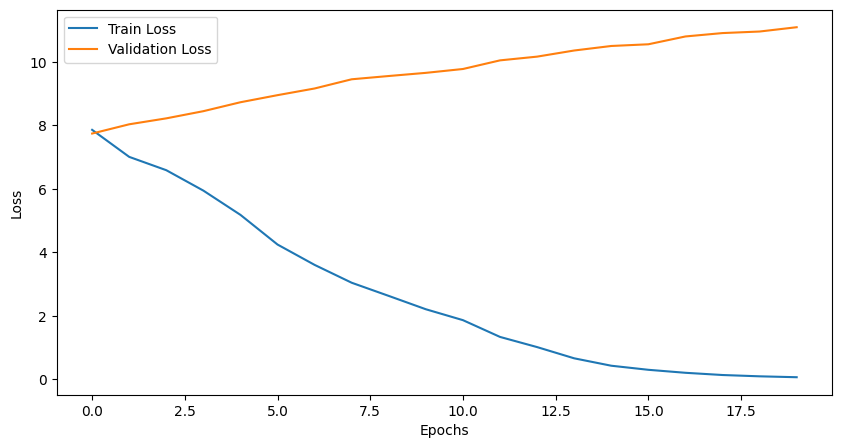

In [ ]:
# ============================================================================
# STEP 5: Plot Training Curves
# ============================================================================

plot_training_curves(history)

In [ ]:
# ============================================================================
# STEP 6: Evaluate on Test Set (Run ONCE)
# ============================================================================

test_bleu = evaluate_test_set(model, test_loader, urdu_vocab, eng_vocab, DEVICE)

In [ ]:
# ============================================================================
# STEP 7: Create Results Table
# ============================================================================

create_results_table(history, test_bleu)

Sample Predictions and References:
Prediction: The gas bug of the race and the first person of the present and the first of money, of the Riga Peace the first of the Riga Peace the race
Reference: Lodin also said officials decided to cancel the runoff in order to save Afghans the expense and security risk of another election.
Prediction: As a result, the city of the and World to be the traditional to be the place of a "thorough and in the
Reference: Stone steps are laid along most of the path, and in the steeper sections steel cables provide a supporting handrail.
Prediction: No one of the University in the day that he was not possible that he will be issued by a new in the same way to launch a strong
Reference: Even traditionally, though, not all Sámi have been involved in big scale reindeer husbandry, but lived from fishing, hunting and similar, having reindeer mostly as draft animals.
Prediction: The case was also in the 2008 of the system and are also to see the of the love of the 

In [ ]:
# ============================================================================
# STEP 8: Test Translation on Sample Sentences
# ============================================================================

# Sample Urdu sentences for testing
sample_sentences = [
    "آپ کا نام کیا ہے",  # What is your name?
    "میں ٹھیک ہوں",      # I am fine
    "آج موسم اچھا ہے",   # The weather is good today
]

print("\n" + "=" * 70)
print("SAMPLE TRANSLATIONS")
print("=" * 70)

for urdu_sent in sample_sentences:
    english_translation = translate_sentence(urdu_sent, model, urdu_vocab, eng_vocab, DEVICE)
    print(f"\nUrdu:    {urdu_sent}")
    print(f"English: {english_translation}")

print("=" * 70)

<All keys matched successfully>

In [ ]:
# ============================================================================
# BONUS: Model Architecture Summary
# ============================================================================

print("\n" + "=" * 70)
print("MODEL ARCHITECTURE SUMMARY")
print("=" * 70)
print("\nCustom LSTM Implementation:")
print("  ✓ Custom LSTM Cell with 4 gates (input, forget, cell, output)")
print("  ✓ No usage of nn.LSTM or nn.RNN library")
print("  ✓ Manual implementation of forward pass through LSTM cells")
print("\nEncoder:")
print(f"  - Embedding Layer: {INPUT_DIM} → {EMBED_SIZE}")
print(f"  - Custom LSTM Layers: {NUM_LAYERS} layers, hidden size {HIDDEN_SIZE}")
print("\nDecoder:")
print(f"  - Embedding Layer: {OUTPUT_DIM} → {EMBED_SIZE}")
print(f"  - Bahdanau Attention Mechanism")
print(f"  - Custom LSTM Layers: {NUM_LAYERS} layers, hidden size {HIDDEN_SIZE}")
print(f"  - Output Layer: {HIDDEN_SIZE * 2} → {OUTPUT_DIM}")
print("\nTraining Configuration:")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  - Loss Function: CrossEntropyLoss (ignoring padding)")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Teacher Forcing Ratio: 0.5")
print("\nEvaluation:")
print(f"  - BLEU Score calculated using Moses multi-bleu.perl")
print(f"  - Evaluation on Train, Validation, and Test sets")
print("=" * 70)

Translated: The balance of an organization the US <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> customer's need. <eos> <eos> <eos> <eos> <eos> <eos> customer's need.
